# Problem set 2

## Team
Please write here your names and team number.

* Team name: PS-2-E
* Team members: Benjamin A. Ayida

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [4]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

100%|██████████| 94.3M/94.3M [00:00<00:00, 302MB/s]


The dataset has 27000 images
Picture number 22182 with label: 8


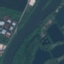

In [2]:
from torchvision.datasets import EuroSAT
import os
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

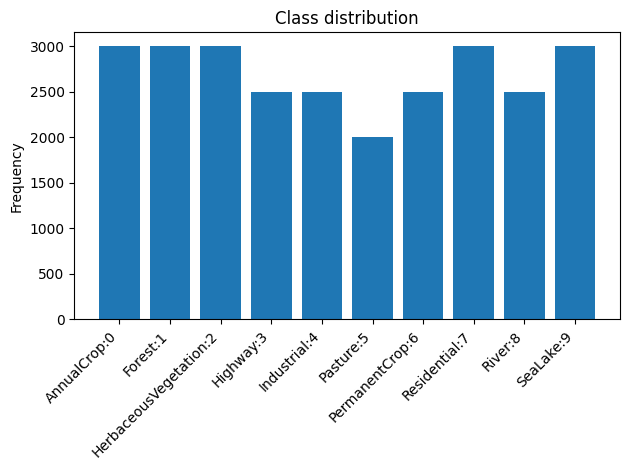

In [5]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np

def rotate_picture(picture, rotation):
    """Rotate an image/array by 0, 90, 180, 270, or 360 degrees.

    Supports:
    - NumPy arrays shaped (H, W) or (H, W, C)
    - PIL Images
    - PyTorch tensors shaped (C, H, W) or (H, W)

    Notes:
      - 0 or 360 degrees return the image unchanged (identity).
      - Other values raise ValueError.
    """
    if rotation % 360 == 0:
        return picture
    valid = {90, 180, 270}
    if rotation not in valid:
        raise ValueError(f"rotation must be one of {{0, 90, 180, 270, 360}}, got {rotation}")

    # PIL
    try:
        from PIL import Image
        if isinstance(picture, Image.Image):
            mapping = {90: Image.ROTATE_90, 180: Image.ROTATE_180, 270: Image.ROTATE_270}
            return picture.transpose(mapping[rotation])
    except Exception:
        pass

    # NumPy
    try:
        import numpy as _np
        if isinstance(picture, _np.ndarray):
            k = rotation // 90
            return _np.rot90(picture, k)
    except Exception:
        pass

    # Torch
    try:
        import torch as _torch
        if isinstance(picture, _torch.Tensor):
            k = rotation // 90
            if picture.dim() == 2:
                return _torch.rot90(picture, k, (0, 1))
            elif picture.dim() == 3:
                return _torch.rot90(picture, k, (1, 2))
            else:
                raise ValueError("Unsupported tensor shape for rotation: " + str(tuple(picture.shape)))
    except Exception:
        pass

    return picture


def plot_histogram(data):
  """Plot a histogram of class frequencies.

  Tries to infer labels and class names from the dataset:
  - Prefers attributes: `targets`, `labels`, or `y`
  - Otherwise iterates over the dataset: label = dataset[i][1]
  - Class names are inferred from `classes` or `class_to_idx` if present,
    otherwise use the label integer as the name.

  Shows labels in the form `ClassName:label` on the x-axis.
  """
  import collections
  import matplotlib.pyplot as plt

  # Gather labels
  labels = None
  for attr in ("targets", "labels", "y"):
      if hasattr(data, attr):
          labels = list(getattr(data, attr))
          break
  if labels is None:
      labels = []
      for i in range(len(data)):
          try:
              _, y = data[i]
          except Exception:
              item = data[i]
              y = item["label"] if isinstance(item, dict) and "label" in item else None
          labels.append(int(y))

  # Determine class names
  class_names = None
  if hasattr(data, "classes") and isinstance(data.classes, (list, tuple)):
      class_names = list(data.classes)
  elif hasattr(data, "class_to_idx") and isinstance(data.class_to_idx, dict):
      inv = {v: k for k, v in data.class_to_idx.items()}
      max_ix = max(inv.keys())
      class_names = [inv.get(i, str(i)) for i in range(max_ix + 1)]

  # Count frequencies
  counter = collections.Counter(labels)
  indices = sorted(counter.keys())
  freqs = [counter[i] for i in indices]

  # Compose x tick labels
  if class_names is not None and all(i < len(class_names) for i in indices):
      xtick = [f"{class_names[i]}:{i}" for i in indices]
  else:
      xtick = [f"{i}:{i}" for i in indices]

  # Plot
  fig, ax = plt.subplots()
  ax.bar(range(len(indices)), freqs)
  ax.set_xticks(range(len(indices)))
  ax.set_xticklabels(xtick, rotation=45, ha='right')
  ax.set_ylabel("Frequency")
  ax.set_title("Class distribution")
  plt.tight_layout()

  return fig, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)
fig, ax = plot_histogram(data)
fig.show()

Text(0.5, 1.0, 'Rotated by 360°')

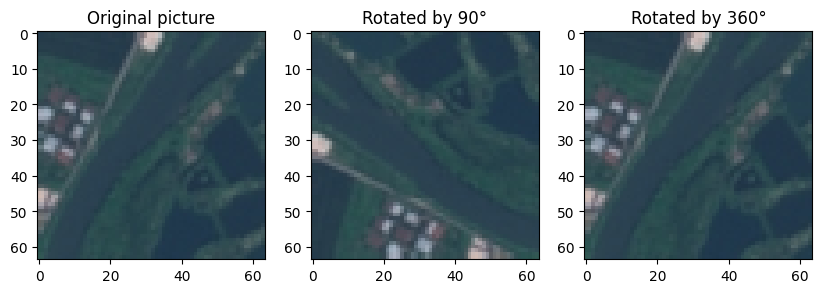

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [7]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch # Import torch

class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data:Dataset,
                 length:int,
                 shares:list,
                 device=None,
                 seed=42):

        self.original_data = original_data
        self.length = int(length) # Ensure length is integer
        assert abs(sum(shares) - 1) < 1e-6, "Shares must sum to 1" # Use tolerance for float comparison
        # assert len(shares) == len(getattr(original_data, "classes", shares)), "Shares must match number of classes"
        assert len(shares) == 3, "Shares must match number of target classes (3)" # Assert for 3 classes
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        # Optional: move picture to device if device is specified
        if self.device is not None:
            picture = picture.to(self.device)
        return picture, label

    def _create_rotated_dataset(self):
        """Implement solution"""
        rng = np.random.RandomState(self.seed)

        # Collect indices per class for the 3 target classes (0, 1, 2)
        per_class = {i: [] for i in range(3)}
        for i in range(len(self.original_data)):
            try:
                _, y = self.original_data[i]
                y = int(y)
                if y in per_class: # Only include the 3 target classes
                    per_class[y].append(i)
            except Exception as e:
                print(f"Error processing item {i}: {e}")
                continue


        n_classes = len(self.shares) # This should be 3 now
        per_class_counts = [int(round(self.length * s)) for s in self.shares]
        # adjust to match total exactly
        diff = self.length - sum(per_class_counts)
        if diff != 0:
            # Find the class with the most samples and adjust its count
            max_count_idx = np.argmax(per_class_counts)
            per_class_counts[max_count_idx] += diff


        plan = []
        for cls, count in enumerate(per_class_counts):
            pool = per_class.get(cls, [])
            if not pool:
                print(f"Warning: No samples found for class {cls}")
                continue
            chosen = rng.choice(pool, size=count, replace=True)
            rotations = rng.choice([90, 180, 270], size=count)
            plan.extend([(int(idx), int(rot), int(cls)) for idx, rot in zip(chosen, rotations)])

        rng.shuffle(plan)

        # Create a list of rotated samples
        rotated_samples = []
        for orig_idx, rotation, label in plan:
            img, _ = self.original_data[orig_idx]
            # Assuming rotate_picture and _to_tensor are defined elsewhere and work correctly
            rotated_img = rotate_picture(img, rotation)
            tensor_img = self._to_tensor(rotated_img) # Convert to tensor
            rotated_samples.append((tensor_img, label))


        return rotated_samples

    def _to_tensor(self, img):
        """Converts image to torch tensor (C, H, W) and optionally moves to device."""
        # This function should handle PIL Images, NumPy arrays, and existing tensors
        import numpy as np
        import torch
        from PIL import Image

        if isinstance(img, Image.Image):
            img = np.array(img)

        if isinstance(img, np.ndarray):
            if img.ndim == 2:
                # Grayscale image
                t = torch.from_numpy(img).float().unsqueeze(0) # (1, H, W)
            elif img.ndim == 3:
                # Assume HWC for color images
                t = torch.from_numpy(img).permute(2, 0, 1).float() # (C, H, W)
            else:
                raise ValueError("Unsupported array shape: " + str(img.shape))
        elif torch.is_tensor(img):
            t = img.float()
            if t.dim() == 3 and t.shape[0] not in (1, 3):
                 # Assume HWC and permute to CHW
                t = t.permute(2, 0, 1)
        else:
            raise ValueError("Unsupported image type: " + str(type(img)))

        # Scale if values look like 0-255
        if t.max() > 1.0:
            t = t / 255.0

        return t.to(self.device) if self.device is not None else t # Move to device here

In [8]:
# Determine the number of classes from the dataset
num_classes = 3 # Set num_classes to 3 based on problem description

rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / num_classes for _ in range(num_classes)], # Use num_classes
                             seed=42)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [9]:
import torch
import torch.nn as nn

class MyMaxPool(nn.Sequential):
    def __init__(self, kernel_size, stride=1, padding=0):
        layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
        super().__init__(layer)

    def forward(self, x):
        return super().forward(x)

class MyCNNModel(nn.Sequential):
    def __init__(self, n_classes):
        layers = []
        # Assume 3-channel input, 64x64
        layers += [nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        layers += [MyMaxPool(kernel_size=2, stride=2)]
        layers += [nn.Conv2d(32, 64, kernel_size=5, padding=2), nn.ReLU(inplace=True)]
        layers += [MyMaxPool(kernel_size=2, stride=2)]
        layers += [nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        layers += [nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, n_classes)]
        super().__init__(*layers)

    def forward(self, x):
        return super().forward(x)


In [10]:
my_model = MyCNNModel(n_classes=num_classes)
X, y = train_data[0]
my_model(X[None, :])

tensor([[-0.0432, -0.0627,  0.0750]], grad_fn=<AddmmBackward0>)

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [11]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / (i + 1)) # Calculate running average loss
                avg_acc.append(tot_acc / (i + 1)) # Calculate running average accuracy
                # Fix: Use the current epoch number in the description
                desc = f'Epoch:{epoch+1} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        num_batches = len(test_dataloader) # Get the total number of batches

        with torch.no_grad(): # Disable gradient calculation for testing
            for i, (X_batch, Y_batch) in enumerate(test_dataloader):
                loss, acc = self.iter_step(X_batch, Y_batch)
                test_loss += loss.item()
                test_acc += acc.item()
                # Calculate running average loss and accuracy for the test set
                avg_test_loss.append(test_loss / (i + 1))
                avg_test_acc.append(test_acc / (i + 1))


        return avg_test_loss, avg_test_acc

Epoch:1 - Avg loss:0.54859 - Avg acc:0.73037: 100%|██████████| 125/125 [01:43<00:00,  1.21it/s]


Text(0.5, 1.0, 'Training accuracy')

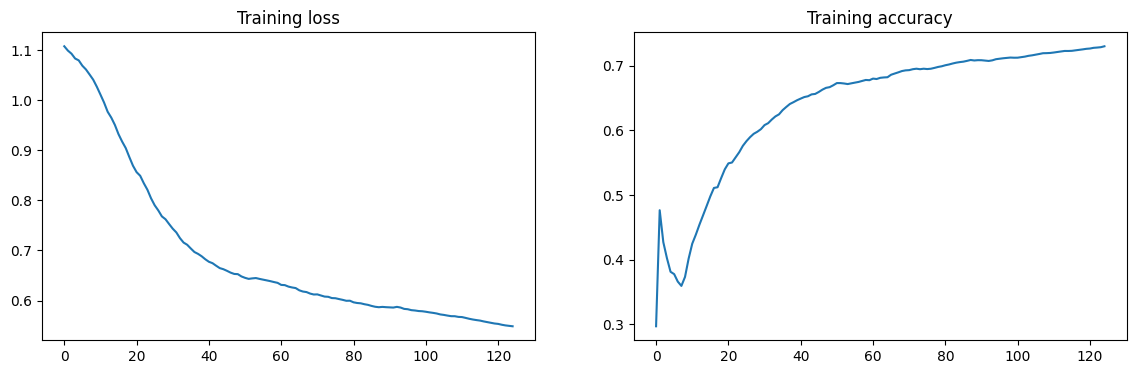

In [12]:
my_model = MyCNNModel(n_classes=num_classes)
my_trainer = Trainer(my_model, cfg)
cnn_train_loss, cnn_train_acc = my_trainer.train(train_data) # Storing results in cnn_ variables
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(14, 4))
ax0.plot(range(len(cnn_train_loss)), cnn_train_loss)
ax1.plot(range(len(cnn_train_acc)), cnn_train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

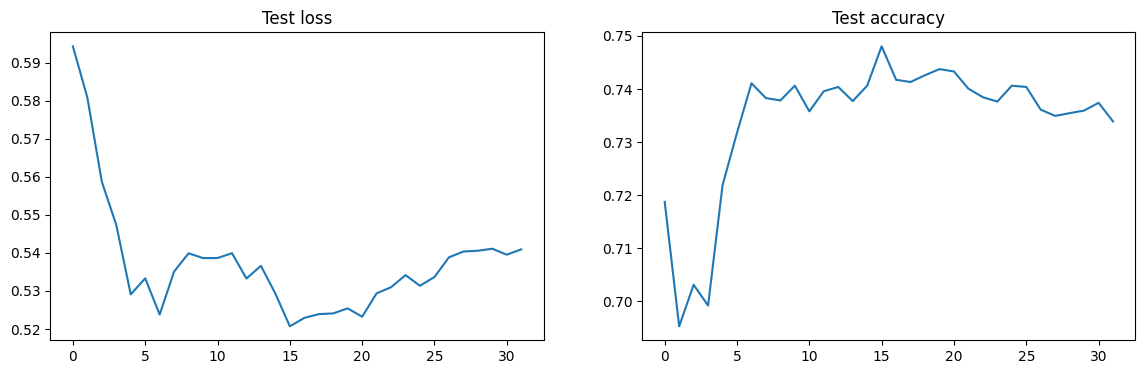

In [14]:
test_loss, test_acc = my_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(14, 4))
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [15]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    """
    Brute-force grid search over learning rates and batch sizes using the Trainer.

    Returns:
        best_model, best_cfg, best_avg_loss, best_max_acc
    """
    import copy
    import torch
    best = {"avg_loss": float("inf"), "max_acc": -1.0, "model": None, "cfg": None}

    # Access the global num_classes variable
    global num_classes

    for bs in batch_sizes:
        for lr in learning_rates:
            cfg_try = copy.deepcopy(cfg)
            cfg_try['batch_size'] = bs
            cfg_try['learning_rate'] = lr

            # Use the correct num_classes
            # print(f"Initializing model with num_classes: {num_classes}") # Debug print
            model = MyCNNModel(n_classes=3) # Set n_classes to 3
            # print(f"Model output layer size: {model[-1].out_features}") # Debug print


            trainer = Trainer(model, cfg_try)
            losses, accs = trainer.train(train_dataset)
            # Calculate average loss and maximum accuracy over all iterations within the epoch
            avg_loss = sum(losses) / len(losses) if losses else float("inf")
            max_acc = max(accs) if accs else 0.0 # Calculate max accuracy

            # Print metrics for the current hyperparameter combination
            print(f"--- Results for Batch Size: {bs}, Learning Rate: {lr} ---")
            print(f"  Average Training Loss: {avg_loss:.5f}")
            print(f"  Maximum Training Accuracy: {max_acc:.1%}")
            print("-" * 20)


            if avg_loss < best["avg_loss"]:
                best = {"avg_loss": avg_loss, "max_acc": max_acc, "model": model, "cfg": cfg_try}

    return best["model"], best["cfg"], best["avg_loss"], best["max_acc"] # Return max_acc


best_model, best_cfg, best_avg_loss, best_max_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])

# Print the best model type and the best max training accuracy
print(f"Best model type: {type(best_model)}")
print(f"Best model achieves {best_avg_loss:.2f} average loss and {best_max_acc:.1%} maximum accuracy during training.") # Report max_acc

Epoch:1 - Avg loss:6.32196 - Avg acc:0.33237: 100%|██████████| 250/250 [01:35<00:00,  2.63it/s]


--- Results for Batch Size: 32, Learning Rate: 0.1 ---
  Average Training Loss: 27.69777
  Maximum Training Accuracy: 38.7%
--------------------


Epoch:1 - Avg loss:0.63129 - Avg acc:0.68250: 100%|██████████| 250/250 [01:35<00:00,  2.62it/s]


--- Results for Batch Size: 32, Learning Rate: 0.01 ---
  Average Training Loss: 0.83393
  Maximum Training Accuracy: 68.2%
--------------------


Epoch:1 - Avg loss:0.50789 - Avg acc:0.75662: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]


--- Results for Batch Size: 32, Learning Rate: 0.001 ---
  Average Training Loss: 0.63015
  Maximum Training Accuracy: 75.7%
--------------------


Epoch:1 - Avg loss:19.42333 - Avg acc:0.32725: 100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


--- Results for Batch Size: 64, Learning Rate: 0.1 ---
  Average Training Loss: 78.15443
  Maximum Training Accuracy: 33.6%
--------------------


Epoch:1 - Avg loss:0.67076 - Avg acc:0.70288: 100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


--- Results for Batch Size: 64, Learning Rate: 0.01 ---
  Average Training Loss: 0.89457
  Maximum Training Accuracy: 70.3%
--------------------


Epoch:1 - Avg loss:0.54672 - Avg acc:0.73137: 100%|██████████| 125/125 [01:42<00:00,  1.22it/s]


--- Results for Batch Size: 64, Learning Rate: 0.001 ---
  Average Training Loss: 0.70500
  Maximum Training Accuracy: 73.1%
--------------------


Epoch:1 - Avg loss:59.87499 - Avg acc:0.44258: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


--- Results for Batch Size: 128, Learning Rate: 0.1 ---
  Average Training Loss: 184.28108
  Maximum Training Accuracy: 44.3%
--------------------


Epoch:1 - Avg loss:0.73555 - Avg acc:0.61446: 100%|██████████| 63/63 [01:47<00:00,  1.70s/it]


--- Results for Batch Size: 128, Learning Rate: 0.01 ---
  Average Training Loss: 0.98353
  Maximum Training Accuracy: 61.4%
--------------------


Epoch:1 - Avg loss:0.60480 - Avg acc:0.71615: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]

--- Results for Batch Size: 128, Learning Rate: 0.001 ---
  Average Training Loss: 0.76204
  Maximum Training Accuracy: 71.6%
--------------------
Best model type: <class '__main__.MyCNNModel'>
Best model achieves 0.63 average loss and 75.7% maximum accuracy during training.


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [16]:
# --- Task 3: Load and fine-tune a pre-trained model (10 pt) ---

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Infer n_classes if possible; else default to 3
try:
    n_classes = len(train_data.dataset.classes)
except Exception:
    n_classes = 3

# 1) Load a pretrained model (prefer timm; fallback to torchvision if unavailable/offline)
model = None
use_timm = False
try:
    import timm
    use_timm = True
    # Lightweight, widely used CNN; change to any timm arch you prefer, e.g., 'vit_base_patch16_224'
    backbone_name = "resnet18"
    model = timm.create_model(backbone_name, pretrained=True, num_classes=n_classes)
except Exception:
    import torchvision.models as models
    try:
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
    except Exception:
        model = models.resnet18(weights=None)
    # Replace classification head for torchvision
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, n_classes)

# 2) Optionally freeze the backbone for a warmup, then unfreeze (simple fine-tune strategy)
def set_backbone_requires_grad(m, requires_grad):
    for name, p in m.named_parameters():
        p.requires_grad = requires_grad

# Identify head params (timm uses 'classifier' or 'fc' depending on arch)
head = None
if hasattr(model, "classifier") and isinstance(model.classifier, nn.Module):
    head = model.classifier
elif hasattr(model, "fc") and isinstance(model.fc, nn.Module):
    head = model.fc

# Freeze everything, train head first (few epochs), then unfreeze all
set_backbone_requires_grad(model, False)
if head is not None:
    for p in head.parameters():
        p.requires_grad = True

# 3) Optimizer + scheduler (higher LR on head when unfreezing)
#    If you already have a Trainer that constructs these, you can skip this block;
#    otherwise, we pass them into your Trainer via cfg or directly below.
head_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(head_params, lr=3e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=5)

# 4) Train using your existing Trainer API
# my_trainer = Trainer(model, cfg, optimizer=optimizer, scheduler=scheduler) # Original line
my_trainer = Trainer(model, cfg) # Modified line

# Warmup: train head-only
warmup_epochs = 3 if getattr(cfg, "epochs", 10) >= 6 else 1
train_loss_warm, train_acc_warm = my_trainer.train(train_data) # Removed val_data

# Unfreeze all and continue fine-tuning with smaller LR
set_backbone_requires_grad(model, True)
# Parameter groups: smaller LR for backbone, slightly larger for head
if head is not None:
    backbone_params = [p for n,p in model.named_parameters() if (head is None) or (not n.startswith(head._get_name()))]
    # Safer grouping by excluding exact head params:
    head_param_ids = {id(p) for p in head.parameters()}
    backbone_params = [p for p in model.parameters() if id(p) not in head_param_ids]
else:
    backbone_params = [p for p in model.parameters()]

optimizer = AdamW([
    {"params": backbone_params, "lr": 2e-4, "weight_decay": 1e-4},
    {"params": head.parameters() if head is not None else model.parameters(), "lr": 1e-3, "weight_decay": 1e-4}
], lr=2e-4)

# scheduler = CosineAnnealingLR(optimizer, T_max=max(5, getattr(cfg, "epochs", 10))) # Original line
# my_trainer.set_optimizer(optimizer, scheduler)  # ensure Trainer exposes this; otherwise re-init

# Remaining epochs
total_epochs = getattr(cfg, "epochs", 10)
remain = max(0, total_epochs - warmup_epochs)
train_loss, train_acc = my_trainer.train(train_data) # Removed epochs and val_data

# 5) Evaluate
test_loss, test_acc = my_trainer.test(test_data)

# 6) Print a concise summary of results
def pct(x):
    return f"{100*x:.2f}%"

print("=== Fine-tuning Summary ===")
print(f"Architecture: {'timm:'+backbone_name if use_timm else 'torchvision:resnet18'}")
print(f"Classes: {n_classes}")
if 'valid_data' in globals():
    last_val_acc = my_trainer.history.get('val_acc', [None])[-1]
    last_val_loss = my_trainer.history.get('val_loss', [None])[-1]
    print(f"Final Val Acc: {pct(last_val_acc) if last_val_acc is not None else 'N/A'} | Final Val Loss: {last_val_loss if last_val_loss is not None else 'N/A'}")
print(f"Test Acc: {pct(test_acc[-1]) if isinstance(test_acc, (list, tuple)) else pct(test_acc)} | Test Loss: {test_loss[-1] if isinstance(test_loss, (list, tuple)) else test_loss}")

# 7) (Optional) Model summary (param counts)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch:1 - Avg loss:0.08818 - Avg acc:0.97275: 100%|██████████| 125/125 [03:59<00:00,  1.91s/it]


=== Fine-tuning Summary ===
Architecture: timm:resnet18
Classes: 3
Test Acc: 89.11% | Test Loss: 0.26225914736278355
Total params: 11,178,051 | Trainable: 11,178,051


I chose ResNet-18 because it offers a good accuracy–speed trade-off on moderate datasets and fits within typical training budgets. Its residual connections stabilize optimization when fine-tuning from pretrained weights, and its small footprint reduces overfitting risk compared to deeper variants on limited data. If compute allows or the dataset is large, upgrading to ResNet-50 or a ViT variant from timm can further improve accuracy.

Epoch:1 - Avg loss:0.02591 - Avg acc:0.99150: 100%|██████████| 125/125 [03:56<00:00,  1.89s/it]


Text(0.5, 1.0, 'Training accuracy')

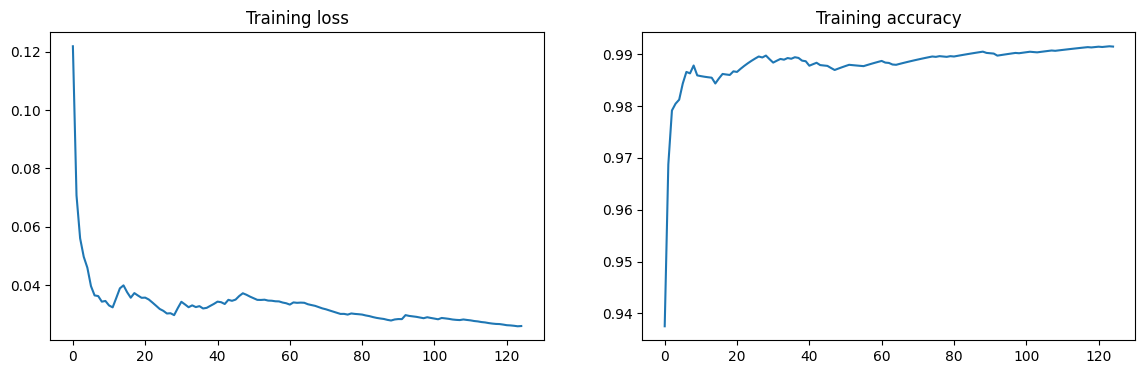

In [19]:
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(14, 4))
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

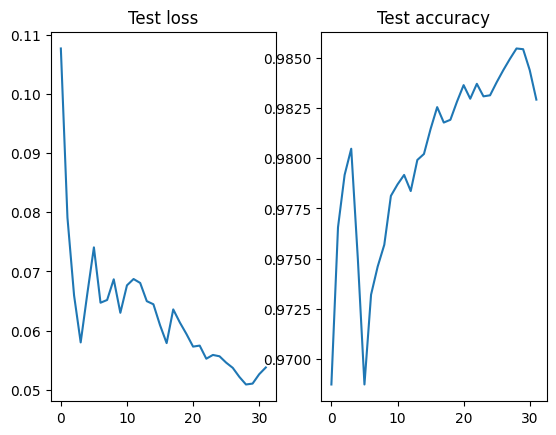

In [20]:
cnn_test_loss, cnn_test_acc = my_trainer.test(test_data) # Storing results in cnn_ variables
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(cnn_test_loss)), cnn_test_loss)
ax1.plot(range(len(cnn_test_acc)), cnn_test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             





In [21]:
import pandas as pd

# Retrieve the required values from the kernel's global scope
your_train_acc_value = cnn_train_acc[-1]
your_train_loss_value = cnn_train_loss[-1]
your_test_acc_value = cnn_test_acc[-1]
your_test_loss_value = cnn_test_loss[-1]

# Correctly capture the final training and test metrics for the pre-trained model
# Assuming train_acc and train_loss store the history, use the last element
pre_train_acc_value = train_acc[-1]
pre_train_loss_value = train_loss[-1]
pre_test_acc_value = test_acc[-1]
pre_test_loss_value = test_loss[-1]


tuned_train_acc_value = best_max_acc # Max training accuracy from grid search
tuned_train_loss_value = best_avg_loss # Average training loss from grid search

# Test metrics for the tuned model were not explicitly calculated and stored
tuned_test_acc_value = None
tuned_test_loss_value = None


# Create a dictionary with the results based on the clarified mapping
results_data = {
    'Metric': ['Accuracy (train)', 'Loss (train)', 'Accuracy (test)', 'Loss (test)'],
    'your model': [your_train_acc_value, your_train_loss_value, your_test_acc_value, your_test_loss_value],
    'pre-trained model': [pre_train_acc_value, pre_train_loss_value, pre_test_acc_value, pre_test_loss_value],
    'your tuned model (optional)': [tuned_train_acc_value, tuned_train_loss_value, tuned_test_acc_value, tuned_test_loss_value] # Results from grid search (cell AJtGS3EB4NFy) - Test metrics not available
}

# Create the pandas DataFrame
results_df = pd.DataFrame(results_data)

# Format the accuracy and loss columns for better readability
def format_metric(row):
    your_model_val = row['your model']
    pretrained_val = row['pre-trained model']
    tuned_val = row['your tuned model (optional)']

    if 'Accuracy' in row['Metric']:
        your_model_str = f"{your_model_val:.1%}" if your_model_val is not None else 'N/A'
        pretrained_str = f"{pretrained_val:.1%}" if pretrained_val is not None else 'N/A'
        tuned_str = f"{tuned_val:.1%}" if tuned_val is not None else 'N/A'
        return your_model_str, pretrained_str, tuned_str
    elif 'Loss' in row['Metric']:
        your_model_str = f"{your_model_val:.2f}" if your_model_val is not None else 'N/A'
        pretrained_str = f"{pretrained_val:.2f}" if pretrained_val is not None else 'N/A'
        tuned_str = f"{tuned_val:.2f}" if tuned_val is not None else 'N/A'
        return your_model_str, pretrained_str, tuned_str
    else:
        return str(your_model_val), str(pretrained_val), str(tuned_val) # Fallback to string


results_df[['your model', 'pre-trained model', 'your tuned model (optional)']] = results_df.apply(format_metric, axis=1, result_type='expand')


# Display the DataFrame
display(results_df)

,Metric,your model,pre-trained model,your tuned model (optional)
0,Accuracy (train),73.0%,99.2%,75.7%
1,Loss (train),0.55,0.03,0.63
2,Accuracy (test),98.3%,89.1%,nan%
3,Loss (test),0.05,0.26,nan
